In [2]:
%pip install -r requirements.txt

  Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached torch-2.2.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached torchvision-0.17.1-cp310-cp310-manylinux1_x86_64.whl.metadata (6.6 kB)
  Using cached pyzbar-0.1.9-py2.py3-none-any.whl.metadata (10 kB)
  Using cached python_barcode-0.15.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached scikit_image-0.22.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached typing_extensions-4.10.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached opencv_python_headless-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadat

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision
from PIL import Image
from tqdm.notebook import tqdm
import os
import random
from sklearn.model_selection import train_test_split

In [38]:
def load_image_paths(root_dir):
    original_dir = os.path.join(root_dir, "original")
    degraded_dir = os.path.join(root_dir, "degraded")
    
    original_images = [os.path.join(original_dir, img) for img in os.listdir(original_dir)]
    degraded_images = [os.path.join(degraded_dir, img) for img in os.listdir(degraded_dir)]
    print(degraded_images[:5])
    # Mapping original to degraded
    mapping = {}
    for orig_path in original_images:
        base_name = os.path.basename(orig_path)
        # print(base_name)
        idx, barcode, _ = base_name.split('_')
        # print([img for img in degraded_images])
        degraded_versions = [img for img in degraded_images if img.startswith(f"../data/ean13/degraded/{idx}_{barcode}")]
        mapping[orig_path] = degraded_versions
    
    return mapping

# Assuming '/data/tmp' is your root directory
root_dir = '../data/ean13'
image_paths = load_image_paths(root_dir)

# Splitting into train and test sets
original_images = list(image_paths.keys())
train_orig, test_orig = train_test_split(original_images, test_size=0.2, random_state=42)

# Creating train and test mappings
train_mapping = {orig: image_paths[orig] for orig in train_orig}
test_mapping = {orig: image_paths[orig] for orig in test_orig}

['../data/ean13/degraded/282_9021415359676_ean13_2.png', '../data/ean13/degraded/308_7480574960796_ean13_23.png', '../data/ean13/degraded/397_1834558412119_ean13_10.png', '../data/ean13/degraded/474_6844512252717_ean13_3.png', '../data/ean13/degraded/185_1480106621887_ean13_6.png']


In [39]:
class ImageDataset(Dataset):
    def __init__(self, mapping, transform=None):
        self.mapping = mapping
        self.transform = transform
        self.original_images = list(mapping.keys())
    
    def __len__(self):
        return len(self.original_images)
    
    def __getitem__(self, idx):
        orig_path = self.original_images[idx]
        degraded_paths = self.mapping[orig_path]
        
        # Example: loading the first degraded image
        degraded_path = random.choice(degraded_paths) # Randomly select one for variability
        orig_image = Image.open(orig_path).convert('L')
        degraded_image = Image.open(degraded_path).convert('L')
        
        if self.transform:
            orig_image = self.transform(orig_image)
            degraded_image = self.transform(degraded_image)
        
        return degraded_image, orig_image

In [40]:
transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
])

train_dataset = ImageDataset(train_mapping, transform=transform)
test_dataset = ImageDataset(test_mapping, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

torch.Size([1, 1, 256, 512])


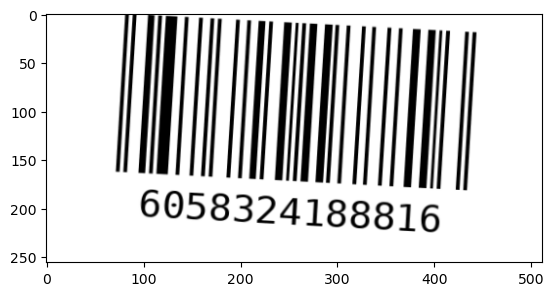

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert a tensor to a numpy array
def imshow(img):
    img = img.numpy() # Convert tensor to numpy array
    plt.imshow(np.transpose(img, (1, 2, 0))) # Convert from CxHxW to HxWxC
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
degraded, original = next(dataiter) # Use next() to get the next batch

# Show images for the first image in the batch
print(degraded[0].unsqueeze(0).shape)
imshow(torchvision.utils.make_grid(degraded[0].unsqueeze(0)))

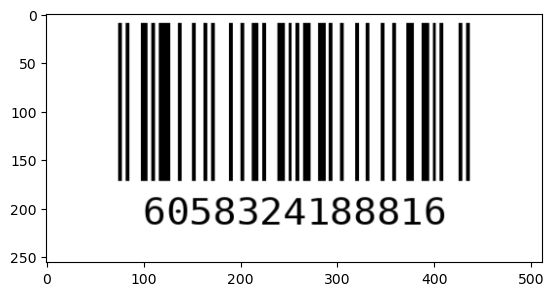

In [42]:
imshow(torchvision.utils.make_grid(original[0].unsqueeze(0)))

In [43]:
from models import Discriminator, Generator

In [44]:
for data in train_loader:
    print(data[0].shape)
    print(data[0][0].shape)
    break

torch.Size([4, 1, 256, 512])
torch.Size([1, 256, 512])


In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [46]:
# Hyperparameters
lr_g = 0.001 #faster lr than discriminator
lr_d = 0.0001
beta1 = 0.5  # For Adam optimizer
epochs = 100
batch_size = 4

# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizerG = optim.Adam(generator.parameters(), lr=lr_g, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, 0.999))

## Training

In [47]:
# Training loop
for epoch in range(epochs):
    num_batches = 0
    for degraded_images, original_images in train_loader: 
        degraded_images, original_images = degraded_images.to(device), original_images.to(device)
        # Prepare real and fake labels and move them to device
        real_labels = torch.ones(batch_size, 1, device=device)  
        fake_labels = torch.zeros(batch_size, 1, device=device)
        
        # Train Discriminator
        discriminator.zero_grad()
        
        # Train with real images
        output = discriminator(original_images)
        lossD_real = criterion(output, real_labels)
        
        # Train with fake images
        # noise = torch.randn(batch_size, 1, 256, 512)
        fake_images = generator(degraded_images)
        output = discriminator(fake_images.detach())  # Detach to avoid training generator
        lossD_fake = criterion(output, fake_labels)
        
        # Backprop and optimize
        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()
        
        # Train Generator
        generator.zero_grad()
        
        output = discriminator(fake_images)
        #the generator's goal is to make the discriminator classify them as real. Therefore, for the purpose of calculating the generator's loss, the target labels are set to be the same as those of real images (i.e., ones).
        lossG = criterion(output, real_labels)  # Trick discriminator into thinking fake is real
        
        lossG.backward()
        optimizerG.step()

        if num_batches % 20 == 0:
            print(f'Epoch [{epoch}/{epochs}], Step [{num_batches}/{len(train_loader)}], LossD: {lossD.item()}, LossG: {lossG.item()}')
        num_batches += 1
    #print average loss after every epoch
    print(f'Epoch [{epoch}/{epochs}], LossD: {lossD.item()}, LossG: {lossG.item()}')

# Save the model
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


Epoch [0/100], Step [0/100], LossD: 1.3849732875823975, LossG: 0.6738670468330383
Epoch [0/100], Step [20/100], LossD: 0.6449851989746094, LossG: 1.1415619850158691
Epoch [0/100], Step [40/100], LossD: 0.03235149383544922, LossG: 4.393020153045654
Epoch [0/100], Step [60/100], LossD: 0.011157454922795296, LossG: 5.175266265869141
Epoch [0/100], Step [80/100], LossD: 0.004716292954981327, LossG: 5.930473327636719
Epoch [0/100], LossD: 0.0024642827920615673, LossG: 6.573445796966553
Epoch [1/100], Step [0/100], LossD: 0.0023467785213142633, LossG: 6.624591827392578
Epoch [1/100], Step [20/100], LossD: 0.0017004520632326603, LossG: 6.930951118469238
Epoch [1/100], Step [40/100], LossD: 0.0014732730342075229, LossG: 7.049129962921143
Epoch [1/100], Step [60/100], LossD: 0.0008222495089285076, LossG: 7.599695205688477
Epoch [1/100], Step [80/100], LossD: 0.0006194876041263342, LossG: 7.905341625213623
Epoch [1/100], LossD: 0.0005754386074841022, LossG: 7.9062886238098145
Epoch [2/100], Step

KeyboardInterrupt: 

torch.Size([1, 1, 256, 512])


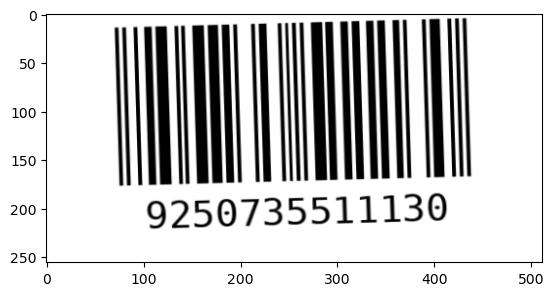

In [30]:
# Get a batch of test
dataiter = iter(test_loader)
degraded, original = next(dataiter) # Use next() to get the next batch

# Show images for the first image in the batch
print(degraded[0].unsqueeze(0).shape)
imshow(torchvision.utils.make_grid(degraded[0].unsqueeze(0)))

In [33]:
generator.eval()
with torch.inference_mode():
    artificial = generator(degraded[0].unsqueeze(0).to(device))

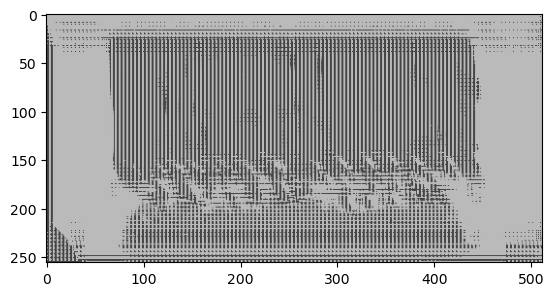

In [36]:
imshow(torchvision.utils.make_grid(artificial.cpu()))

## Next steps
- Add more complex loss functions that capture different parts of the denoising process
- Visualize results every 10 epochs?